In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 18

%matplotlib inline

# Parametric Extrapolation Simulation Example

1. **Confounded DGP:**
$$
X \sim N(0, 1)\\
A \sim Bern(0.5)\\
U \mid X=x, A=a \sim N\left(x\left(a-\frac{1}{2}\right), 1-\left(a-\frac{1}{2}\right)^2\right)\\
Y = 1 + A + X + 2AX + 0.5X^2 + 0.75AX^2 + U + 0.5\epsilon_Y, \quad \epsilon_Y \sim N(0, 1)
$$

2. **IV DGP:**
$$
X \sim N(0, 1), \quad Z \sim Bern(0.5), \quad A^* \sim Bern(0.5)\\
\gamma(X) = \sigma(2X), \quad C \sim Bern(\gamma(X))\\
A = C \cdot Z + (1-C) \cdot A^*\\
U \mid X=x, A=a \sim N\left(x\left(a-\frac{1}{2}\right), 1-\left(a-\frac{1}{2}\right)^2\right)\\
Y = 1 + A + X + 2AX + 0.5X^2 + 0.75AX^2 + U + 0.5\epsilon_Y, \quad \epsilon_Y \sim N(0, 1)
$$
where $\sigma(x) = \frac{1}{1+\exp(-x)}$.

In [2]:
def sigma(x):
    return 1/(1+np.exp(-x))

def y_func(x, a, u):
    return (1 + a + x + 2*a*x + 0.5*x**2 + 0.75*a*x**2 + u)

def true_tau(x):
    return 0.75*x**2 + 2*x + 1

In [3]:
# DGP parameters
n_O = 5000
n_E = 5000

# Test data
X_test = np.arange(-3, 3, 0.01)
np.random.seed(1)

In [4]:
# Observational data
X_O = np.random.normal(size=n_O, scale=1)
A_O = np.random.binomial(1, 0.5, size=n_O)
U_O = np.random.normal(X_O*(A_O-0.5), np.sqrt(1-(A_O-0.5)**2))
eps_O = np.random.normal(size=n_O)/2
Y_O = np.array([y_func(X_O[i], A_O[i], U_O[i]) for i in range(n_O)]) + eps_O

In [5]:
# Experimental data
X_E = np.random.normal(size=n_E, scale=1)
Z_E = np.random.binomial(1, 0.5, size=n_E)
gamma_X = np.vectorize(sigma)(2*X_E)
C = np.random.binomial(1, gamma_X)
A_star = np.random.binomial(1, 0.5, size=n_E)
A_E = C * Z_E + (1-C) * A_star
U_E = C*np.random.normal(size=n_E) + (1-C)*np.random.normal(X_E*(A_E-0.5), np.sqrt(1-(A_E-0.5)**2))
eps_E = np.random.normal(size=n_E)/2
Y_E = np.array([y_func(X_E[i], A_E[i], U_E[i]) for i in range(n_E)]) + eps_E

### 1. Learn $\widehat{\tau}^O(x)$

In [6]:
# Learn observational tau
mu1_model =  RandomForestRegressor(max_depth=5, min_samples_leaf=5)
mu1_model.fit(X_O[A_O==1].reshape(-1,1), Y_O[A_O==1])
mu0_model = RandomForestRegressor(max_depth=5, min_samples_leaf=5)
mu0_model.fit(X_O[A_O==0].reshape(-1,1), Y_O[A_O==0])
tau_O = mu1_model.predict(X_test.reshape(-1, 1)) - mu0_model.predict(X_test.reshape(-1, 1))

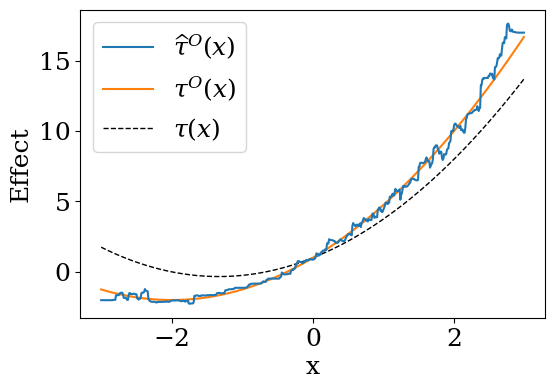

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, tau_O, label=r"$\widehat{\tau}^O(x)$", zorder=10)
plt.plot(X_test, np.vectorize(true_tau)(X_test) + X_test, zorder=5, label=r"$\tau^O(x)$")
plt.plot(X_test, np.vectorize(true_tau)(X_test), label=r"$\tau(x)$", color='black', ls='--', lw=1, zorder=1)
plt.xlabel("x")
plt.ylabel("Effect")
plt.legend()
plt.show()

### 2. Learn $\widehat{\tau}^E(x)$

In [8]:
# Learn IV tau
# Y models
mu1_z_model =  RandomForestRegressor(max_depth=5, min_samples_leaf=5)
mu1_z_model.fit(X_E[Z_E==1].reshape(-1,1), Y_E[Z_E==1])
mu0_z_model = RandomForestRegressor(max_depth=5, min_samples_leaf=5)
mu0_z_model.fit(X_E[Z_E==0].reshape(-1,1), Y_E[Z_E==0])

# A models
pi1_z_model = RandomForestClassifier(max_depth=3, min_samples_leaf=50)
pi1_z_model.fit(X_E[Z_E==1].reshape(-1,1), A_E[Z_E==1])
pi0_z_model = RandomForestClassifier(max_depth=3, min_samples_leaf=50)
pi0_z_model.fit(X_E[Z_E==0].reshape(-1,1), A_E[Z_E==0])

RandomForestClassifier(max_depth=3, min_samples_leaf=50)

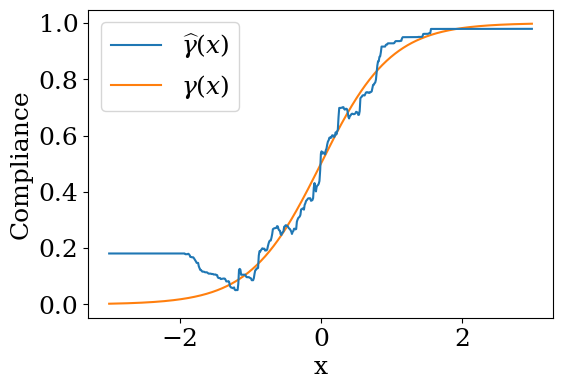

In [9]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, 
         pi1_z_model.predict_proba(X_test.reshape(-1, 1))[:, 1]-pi0_z_model.predict_proba(X_test.reshape(-1, 1))[:, 1], 
         label=r"$\widehat{\gamma}(x)$", zorder=10)
plt.plot(X_test, np.vectorize(sigma)(2*X_test), label=r"$\gamma(x)$")
plt.xlabel("x")
plt.ylabel("Compliance")
plt.legend()
plt.show()

In [10]:
# IV ate
delta_Y_X_test = mu1_z_model.predict(X_test.reshape(-1, 1)) - mu0_z_model.predict(X_test.reshape(-1, 1))
gamma_X_test = np.maximum(pi1_z_model.predict_proba(X_test.reshape(-1, 1))[:, 1] \
                    - pi0_z_model.predict_proba(X_test.reshape(-1, 1))[:, 1], 0.1)
tau_E = delta_Y_X_test / gamma_X_test

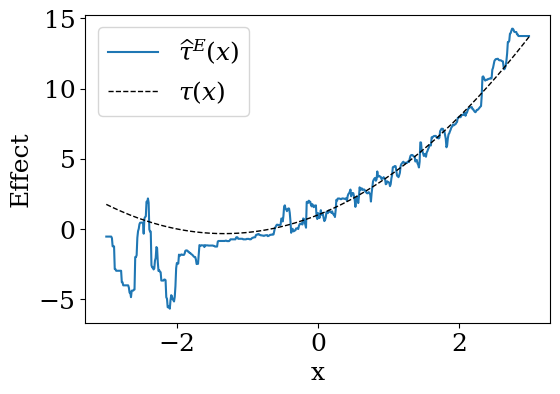

In [11]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, tau_E, label=r"$\widehat{\tau}^E(x)$")
plt.plot(X_test, np.vectorize(true_tau)(X_test), label=r"$\tau(x)$", color='black', ls='--', lw=1)
plt.xlabel("x")
plt.ylabel("Effect")
plt.legend()
plt.show()

### 3. Apply Algorithm 1

In [12]:
# Apply algorithm 1 to learn parametric extension
tau_O_hat = mu1_model.predict(X_E.reshape(-1, 1)) - mu0_model.predict(X_E.reshape(-1, 1))
gamma_X_hat = np.maximum(pi1_z_model.predict_proba(X_E.reshape(-1, 1))[:, 1] - pi0_z_model.predict_proba(X_E.reshape(-1, 1))[:, 1], 0)
tilde_Y = 2*Y_E*Z_E - 2*Y_E*(1-Z_E) - gamma_X_hat*tau_O_hat
tilde_X = X_E * gamma_X_hat
lr = LinearRegression().fit(tilde_X.reshape(-1, 1), tilde_Y)

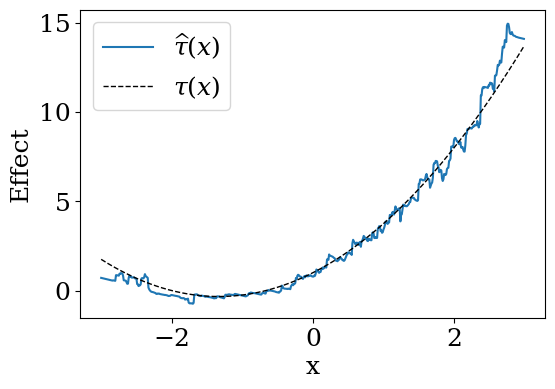

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(X_test, tau_O + lr.predict(X_test.reshape(-1, 1)), label=r"$\widehat{\tau}(x)$")
plt.plot(X_test, np.vectorize(true_tau)(X_test), label=r"$\tau(x)$", color='black', ls='--', lw=1)
plt.xlabel("x")
plt.ylabel("Effect")
plt.legend()
plt.show()

In [14]:
# MSE calculations
oracle_tau = np.vectorize(true_tau)(X_test)
mse = np.sqrt(np.sum((tau_O - oracle_tau)**2)/X_test.shape[0])
print(f"tau_O RMSE: {mse:0.2f}.")

mse = np.sqrt(np.sum((tau_E - oracle_tau)**2)/X_test.shape[0])
print(f"tau_E RMSE: {mse:0.2f}.")

tau_hat = tau_O + lr.predict(X_test.reshape(-1, 1))
mse = np.sqrt(np.sum((tau_hat - oracle_tau)**2)/X_test.shape[0])
print(f"tau_hat RMSE: {mse:0.2f}.")

tau_O RMSE: 1.94.
tau_E RMSE: 1.69.
tau_hat RMSE: 0.54.
